# DistilBert fine-tuning

- 1. Task: DistilBert를 통한 감정 분류입니다. 

        1) 상세 설명: IMDB 영화 리뷰 데이터를 가지고 긍부정 이진 분류를 진행합니다. 

        2) 2주차 과제와 동일한 데이터셋을 사용하고 있기 때문에 데이터셋을 로드하는 과정에서는 2주차와 유사한 코드를 복사하여 사용하겠습니다. 단, 2주차에서 진행하지 않았던 텍스트 길이에 대한 EDA를 진행하겠습니다. 

- 2. 더 해볼 과제:

        1) max_len에 대한 비교

        2) freeze와 full에 대한 비교

- 3. 특이 사항:

        1) parameter 수와 훈련 시간을 비교해보아야 합니다. 왜냐하면 freeze와 full 방식은 훈련 가능한 파라미터 수 차이가 굉장히 크기 때문입니다.

    

## 1. [My Code] Data Load

- 데이터셋을 불러옵니다.

- train, val, test로 분류합니다

    1) train : 25000개

    2) val: 12500개

    3) test: 12500개

- 텍스트의 길이 분포도를 계산하여, max_len의 평균과 표준편차, 중앙값등을 계산해보겠습니다.

### 1.1 [My Code] Model Config

In [39]:
import torch
# 모델 config입니다.
model_name = "distilbert-base-uncased"
ds_name = "stanfordnlp/imdb"

test_size = 0.5
random_state = 42
batch_size = 64
max_len_dict = {'max_len_1' : 400, 'max_len_2': 200}

results_dir = './results/week3_basic'
lr = 0.001
n_epochs = 10

### 1.2 [My Code] Load Data and split it into Train, Val, Test

In [21]:
from transformers import DistilBertTokenizer
from datasets import load_dataset

# distilbert tokenizer를 사용합니다.
# 데이터셋은 imdb 영화 리뷰 데이터입니다.
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
ds = load_dataset(ds_name)

In [19]:
# train, val, test로 데이터 나누기
from sklearn.model_selection import train_test_split 

print(ds, end='\n\n')

x_train = ds['train']['text']
y_train = ds['train']['label']

x_test = ds['test']['text']
y_test = ds['test']['label']

x_val, x_test, y_val, y_test = train_test_split(
    x_test, 
    y_test, 
    test_size=test_size,
    random_state=random_state
)

num = 0

print(f"x_train len: {len(x_train)}")
print(f"y_train len: {len(y_train)}")
print(f"sample train test = label : {y_train[num]}\n text:{x_train[num]}\n")

print(f"x_val len: {len(x_val)}")
print(f"y_val len: {len(y_val)}")
print(f"sample train test = label : {y_val[num]}\n text:{x_val[num]}\n")

print(f"x_test shape: {len(x_test)}")
print(f"y_test len: {len(y_test)}\n")
print(f"sample test test = label : {y_test[num]}\n text:{x_test[num]}\n")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

x_train len: 25000
y_train len: 25000
sample train test = label : 0
 text:I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and ra

### 1.3 [My Code] 텍스트 길이 분포 계산

- 통계량

    1) 평균: 대체로 1300

    2) 표준편차: 대체로 1000

    3) 왜도
        - 대체로 2 정도 나오는 것을 알 수 있습니다. 왜도가 0일 때 정규분포를 그리게 되며 양수일 때 right-skewed, 음수일 때 left-skewed 데이터를 형성합니다. 즉 해당 length 분포는 전체적으로 오른쪽으로 치우쳐있으며 극단적으로 긴 데이터가 존재한다는 것을 알 수 있습니다.

    4) 첨도: 
        - scipy.kurtois로 구한 초과첨도는 0을 기준으로 양수면 정규분포에 비해 봉우리가 훨씬 뾰족하고 음수면 봉우리가 완만합니다. 해당 데이터는 굉장히 봉우리가 뾰족하게 형성되어 있음을 알 수 있습니다. 이는 평균을 기준으로 데이터가 멀리 분포해 있음을 알려줍니다.

- max_len에 따른 metric 변화를 비교해보기 위하여 max_len이 400일 때와 200일 때 2개로 데이터셋을 각각 build해보겠습니다.

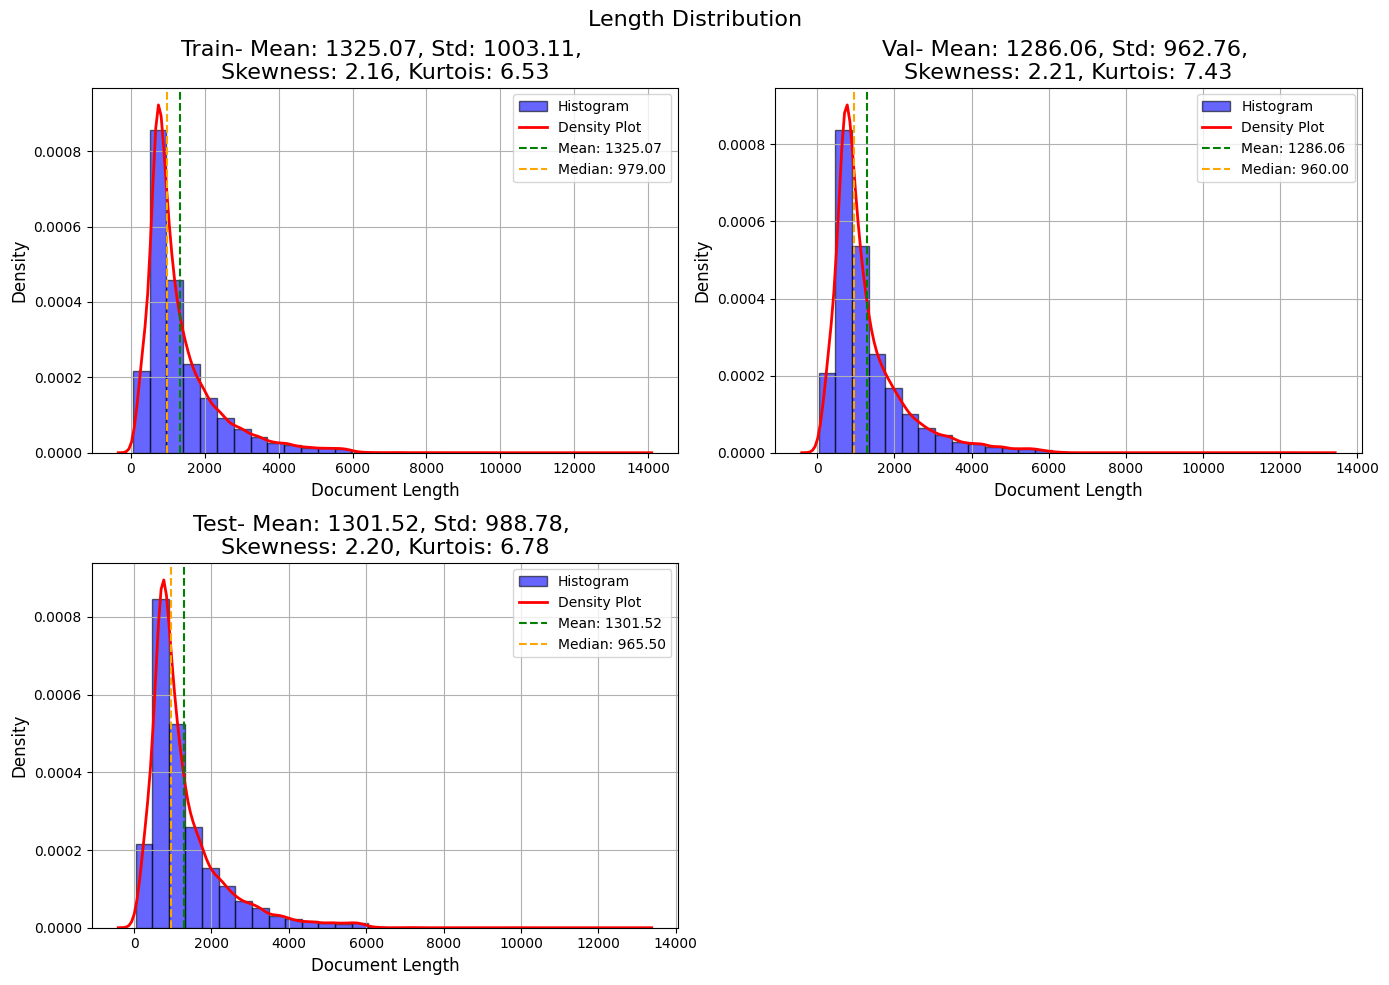

In [20]:
# 평균, 표준편차, 왜도, 첨도 계산산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)
    
    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)


plt.figure(figsize=(14,10))

for i, (data_lst, name) in enumerate(zip([x_train, x_val, x_test],['Train', 'Val', 'Test'])):
    plt.subplot(2,2,i+1)
    length_plot([len(data)for data in data_lst], name)

plt.suptitle("Length Distribution", fontsize=16)
plt.tight_layout()
plt.show()


### 1.4 [My Code] Label Distribution

In [27]:
# 데이터의 라벨, 즉 긍-부정의 비율을 확인합니다.
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.DataFrame(
    [
        pd.Series(y_train).value_counts(normalize=True),
        pd.Series(y_val).value_counts(normalize=True),
        pd.Series(y_test).value_counts(normalize=True),
    ],
    index = ['train','val','test'],
)

display(df)

,0,1
train,0.50000,0.50000
val,0.49536,0.50464
test,0.50464,0.49536


### 1.5 [My Code] 데이터셋 build

- max_len_1 : 400

- max_len_2 : 960

- max_len의 값에 따라서 데이터셋을 2개로 build 합니다.

In [40]:
# 허깅페이스 데이터셋 형태로 바꾸기
from datasets import Dataset, DatasetDict
def tokenize(batch, max_len):
  
  return tokenizer(
    batch["text"], 
    padding="max_length", 
    max_length = max_len, 
    truncation=True, 
    return_tensors = 'pt')


train_data = {
    'text': x_train,
    "label": y_train,
}

val_data = {
    'text': x_val,
    "label": y_val,
}

test_data = {
    'text': x_test,
    "label": y_test,
}

train_dataset = Dataset.from_dict(train_data)
train_dataset = train_dataset.select(range(100))
train_dataset_1 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
train_dataset_2 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)

val_dataset = Dataset.from_dict(val_data)
val_dataset = val_dataset.select(range(100))
val_dataset_1 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
val_dataset_2 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)

test_dataset = Dataset.from_dict(test_data)
test_dataset = test_dataset.select(range(100))
test_dataset_1 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
test_dataset_2 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)

dataset_dict_1 = DatasetDict(
    {
        "train": train_dataset_1,
        "val": val_dataset_1,
        "test": test_dataset_1
    }
)

dataset_dict_2 = DatasetDict(
    {
        "train": train_dataset_2,
        "val": val_dataset_2,
        "test": test_dataset_2
    }
)

dataset_dict = DatasetDict(
    {
        "max_len_1" : dataset_dict_1,
        "max_len_2" : dataset_dict_2,
    }
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## 2.[My Code] Model Load

: 허깅페이스의 trainer로 구현을 하는 것이 이번 과제의 추가 목표입니다.

- 모델을 로드합니다. 이 때, num_labels=2로 하면 이진 분류기 classifer를 달아줍니다.

- metrics: accuracy와 f1 score

- optimizer: Adam

- batch_size = 64, 

- lr = 1e-3

### 2.1 [My Code] Max len에 따른 모델

- 모델 2개를 dict에 묶고, key는 max_len_1, max_len_2로 지정합니다.

- 분류기 이전의 모든 파라미터를 동결시키는 것과 동결시키지 않는 것의 차이를 확인하기 위하여 max_len_1, max_len_2로 freeze하지 않은 모델 또한 선언합니다.

- 따라서, 총 4개의 모델(max_len_1_freeze, max_len_2_freeze, max_len_1_full, max_len_2_full)의 metrics을 비교해보려고 합니다.

In [50]:
from transformers import DistilBertForSequenceClassification
from torchinfo import summary

def build_model(freeze=True):
    # 모델 로드
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    # 분류기 이전의 모든 파라미터 동결
    if freeze:
        for param in model.distilbert.parameters():
            param.requires_grad = False
    return model

model_dict = {
    'max_len_1-freeze' : build_model(freeze=True),
    'max_len_2-freeze' : build_model(freeze=True),
    'max_len_1-full' : build_model(freeze=False),
    'max_len_2-full' : build_model(freeze=False),
}

# 모델 정보 출력
for max_len_type in model_dict.keys():
    print(f"Model Summary: {max_len_type}")
    print(summary(model_dict[max_len_type], input_size=(batch_size, max_len_dict[max_len_type.split('-')[0]]), dtypes=[torch.int64]))
    print("\n\n")

    

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

Model Summary: max_len_1-freeze
Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 2]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─Linear: 1-2                                           [64, 768]                

## 3.[My Code] Training

- huggingface trainer를 사용하여 훈련을 진행합니다.

- 확실히 naive torch 버전으로 모델을 훈련시키는 것보다 코드가 간편해지는 것을 확인할 수 있습니다.

In [77]:
from transformers import TrainingArguments, Trainer
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score
# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 한다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir=results_dir, 
    num_train_epochs=n_epochs,  
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,  
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,  
)

In [78]:
def build_triner(max_len_type, training_args):
    trainer = Trainer(
        model=model_dict[max_len_type],
        args=training_args,
        train_dataset=dataset_dict[max_len_type.split('-')[0]]["train"],
        eval_dataset=dataset_dict[max_len_type.split('-')[0]]["val"],
        compute_metrics=compute_metrics,
        optimizers=(Adam(model_dict[max_len_type].parameters(), lr=lr), None)
    )

    return trainer

trainer_dict = {
    'max_len_1-freeze' : build_triner('max_len_1-freeze', training_args),
    'max_len_2-freeze' : build_triner('max_len_2-freeze', training_args),
    'max_len_1-full' : build_triner('max_len_1-full', training_args),
    'max_len_2-full' : build_triner('max_len_2-full', training_args),
}

In [79]:
trainer_dict['max_len_1-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,7.325198,0.570000,0.413885
2,0.000000,8.313614,0.570000,0.413885
3,0.000000,8.943043,0.570000,0.413885
4,0.000000,9.360824,0.570000,0.413885
5,0.000000,9.640018,0.570000,0.413885
6,0.000000,9.824040,0.570000,0.413885
7,0.000000,9.941212,0.570000,0.413885
8,0.000000,10.011025,0.570000,0.413885
9,0.000000,10.047347,0.570000,0.413885
10,0.000000,10.060200,0.570000,0.413885


TrainOutput(global_step=20, training_loss=2.470166555745834e-07, metrics={'train_runtime': 19.0465, 'train_samples_per_second': 52.503, 'train_steps_per_second': 1.05, 'total_flos': 103490155200000.0, 'train_loss': 2.470166555745834e-07, 'epoch': 10.0})

In [80]:
trainer_dict['max_len_2-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,7.105745,0.570000,0.413885
2,0.000000,8.097258,0.570000,0.413885
3,0.000000,8.733233,0.570000,0.413885
4,0.000000,9.156983,0.570000,0.413885
5,0.000000,9.441057,0.570000,0.413885
6,0.000000,9.628745,0.570000,0.413885
7,0.000000,9.748477,0.570000,0.413885
8,0.000000,9.819929,0.570000,0.413885
9,0.000000,9.857150,0.570000,0.413885
10,0.000000,9.870335,0.570000,0.413885


TrainOutput(global_step=20, training_loss=3.176313426500599e-07, metrics={'train_runtime': 9.8274, 'train_samples_per_second': 101.756, 'train_steps_per_second': 2.035, 'total_flos': 51745077600000.0, 'train_loss': 3.176313426500599e-07, 'epoch': 10.0})

In [81]:
trainer_dict['max_len_1-full'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,9.067677,0.570000,0.413885
2,0.000000,9.592759,0.570000,0.413885
3,0.000000,9.878502,0.570000,0.413885
4,0.000000,10.051783,0.570000,0.413885
5,0.000000,10.160629,0.570000,0.413885
6,0.000000,10.229286,0.570000,0.413885
7,0.000000,10.271663,0.570000,0.413885
8,0.000000,10.296379,0.570000,0.413885
9,0.000000,10.309042,0.570000,0.413885
10,0.000000,10.313476,0.570000,0.413885


TrainOutput(global_step=20, training_loss=1.1175870007207323e-09, metrics={'train_runtime': 138.7975, 'train_samples_per_second': 7.205, 'train_steps_per_second': 0.144, 'total_flos': 103490155200000.0, 'train_loss': 1.1175870007207323e-09, 'epoch': 10.0})

In [82]:
trainer_dict['max_len_2-full'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,10.318408,0.570000,0.413885
2,0.000000,10.212151,0.570000,0.413885
3,0.000000,10.083349,0.570000,0.413885
4,0.000000,10.009138,0.570000,0.413885
5,0.000000,9.978911,0.570000,0.413885
6,0.000000,9.975472,0.570000,0.413885
7,0.000000,9.983910,0.570000,0.413885
8,0.000000,9.995786,0.570000,0.413885
9,0.000000,10.005492,0.570000,0.413885
10,0.000000,10.010185,0.570000,0.413885


TrainOutput(global_step=20, training_loss=9.778886322919788e-09, metrics={'train_runtime': 22.0383, 'train_samples_per_second': 45.376, 'train_steps_per_second': 0.908, 'total_flos': 51745077600000.0, 'train_loss': 9.778886322919788e-09, 'epoch': 10.0})

## 4.[My Code] Metric Plotting

In [85]:
# 테스트 데이터셋에 대한 예측 및 평가
def cal_metrics(max_len_type):
    test_results = trainer_dict[max_len_type].predict(test_dataset=dataset_dict[max_len_type.split('-')[0]]["test"])
    metrics = test_results.metrics
    print(f"Test {max_len_type} Metrics:", "\n", "loss: ", metrics['test_loss'], "accuracy: ", metrics['test_accuracy'], "f1:", metrics['test_f1'])
    return metrics

metrics_dict = {
    'max_len_1-freeze': cal_metrics('max_len_1-freeze'),
    'max_len_2-freeze': cal_metrics('max_len_2-freeze'),
    'max_len_1-full': cal_metrics('max_len_1-full'),
    'max_len_2-full': cal_metrics('max_len_2-full'),
    }

Test max_len_1-freeze Metrics: 
 loss:  12.529437065124512 accuracy:  0.47 f1: 0.30054421768707484


Test max_len_2-freeze Metrics: 
 loss:  12.261012077331543 accuracy:  0.47 f1: 0.30054421768707484


Test max_len_1-full Metrics: 
 loss:  12.71330451965332 accuracy:  0.47 f1: 0.30054421768707484


Test max_len_2-full Metrics: 
 loss:  12.352952003479004 accuracy:  0.47 f1: 0.30054421768707484


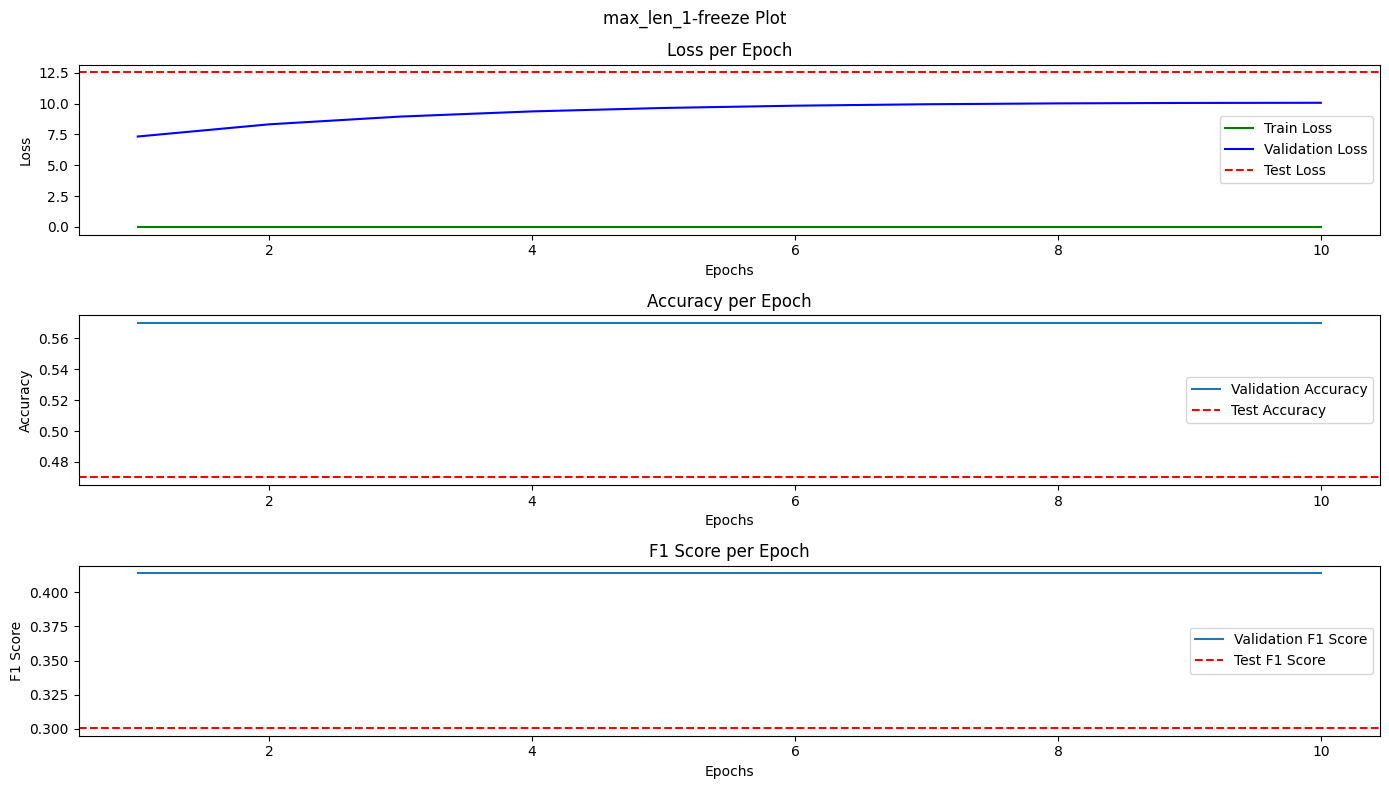

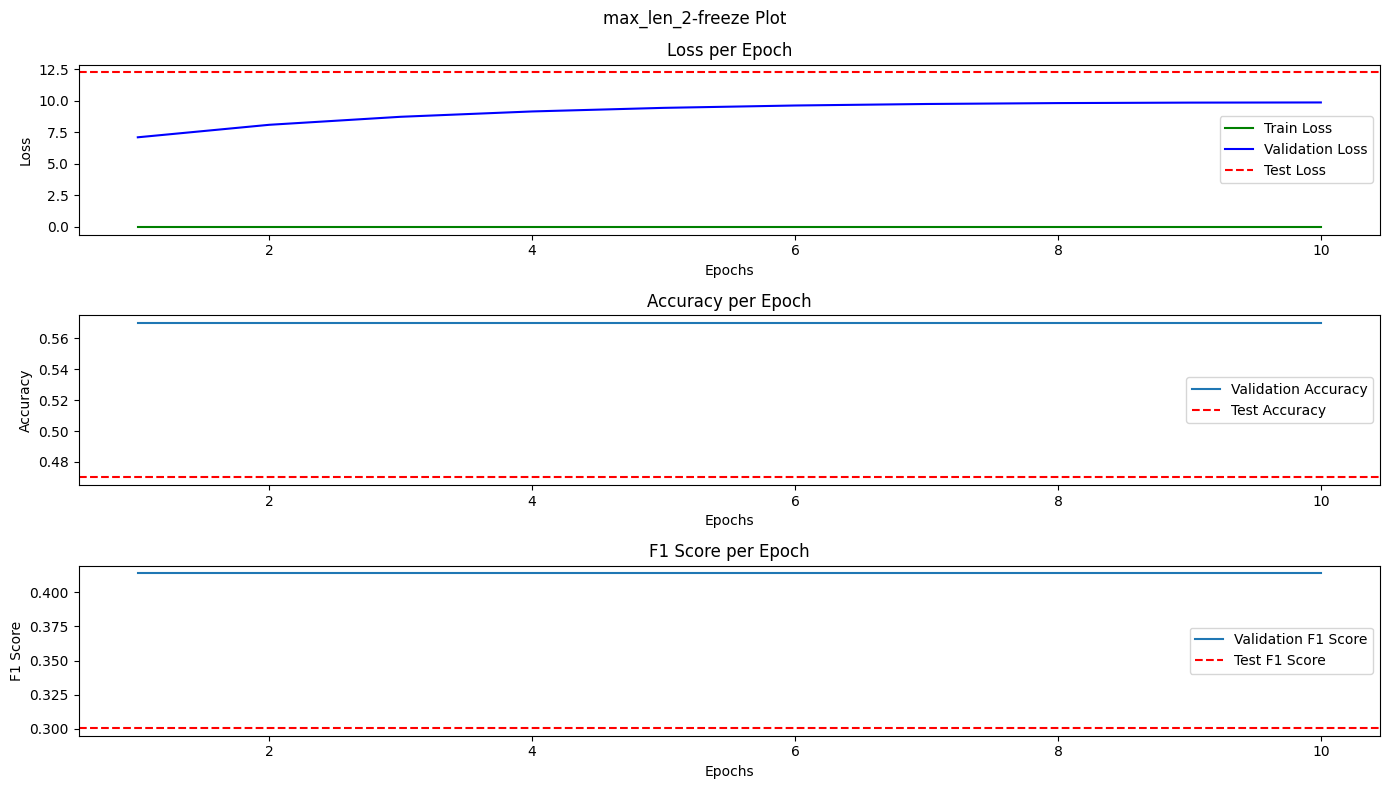

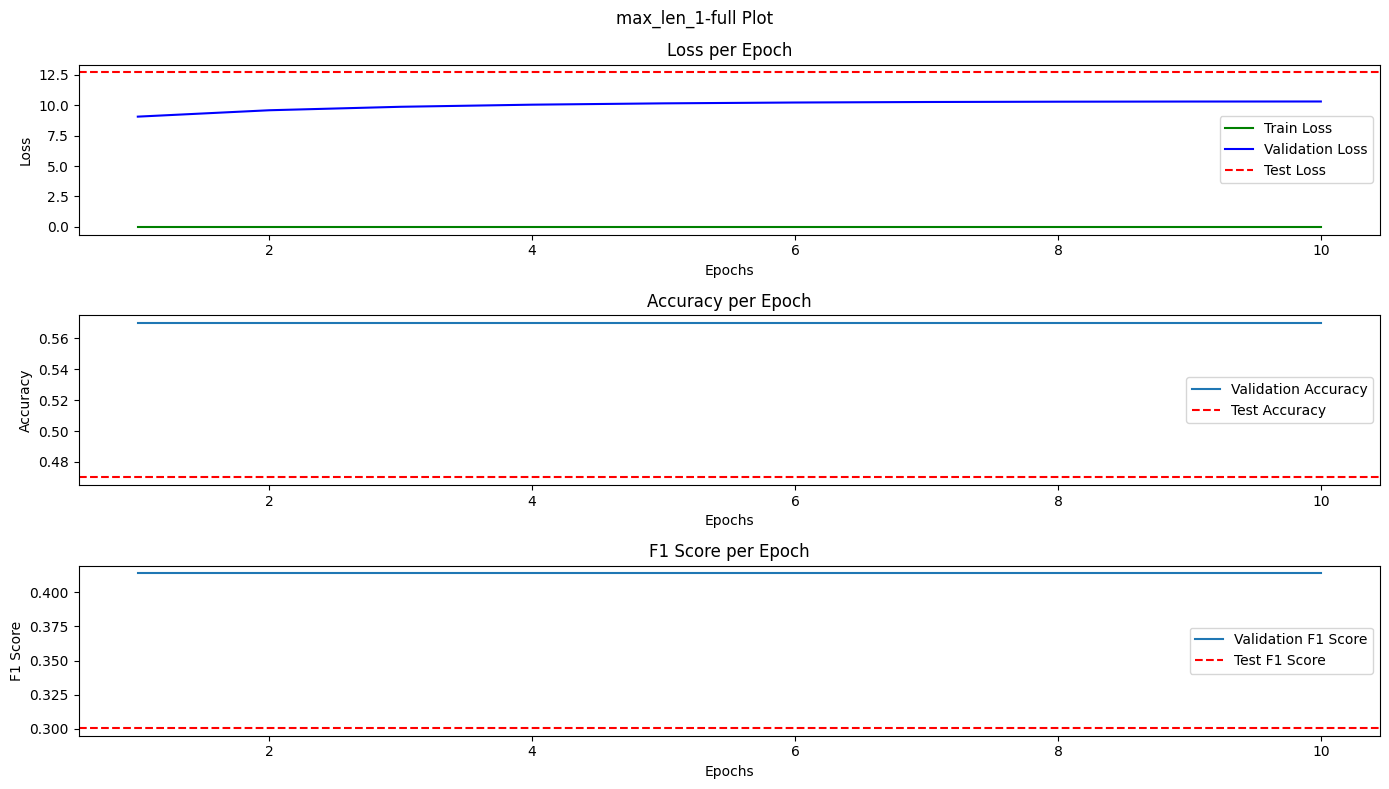

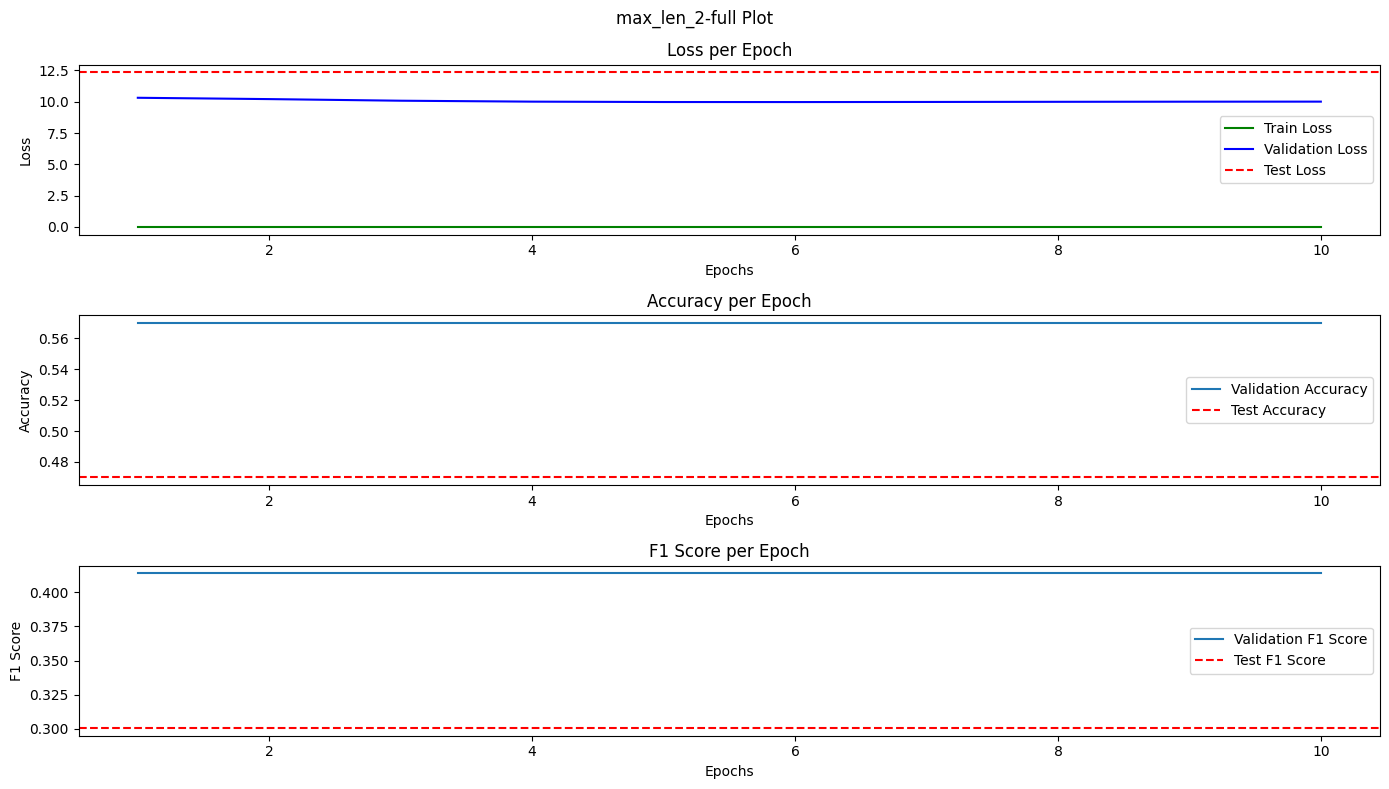

In [86]:
import matplotlib.pyplot as plt

def plotting(max_len_type):
    # 로그 데이터 추출
    log_history = trainer_dict[max_len_type].state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])

    test_loss = metrics_dict[max_len_type]['test_loss']
    test_accuracy = metrics_dict[max_len_type]['test_accuracy']
    test_f1 = metrics_dict[max_len_type]['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()

    plt.suptitle(f"{max_len_type} Plot")
    plt.tight_layout()
    print("\n\n")

plotting('max_len_1-freeze')
plotting('max_len_2-freeze')
plotting('max_len_1-full')
plotting('max_len_2-full')
plt.show()

In [93]:
import pandas as pd

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model_dict[name]) for name in metrics_dict.keys()]
train_runtime_lst = [trainer_dict[name].state.log_history[-1]['train_runtime'] for name in  metrics_dict.keys()]

result_df = pd.DataFrame(metrics_dict).T
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']]

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
max_len_1-freeze,12.529437,0.47,0.300544,592130,19.0465,3.3507
max_len_2-freeze,12.261012,0.47,0.300544,592130,9.8274,1.4062
max_len_1-full,12.713305,0.47,0.300544,66955010,138.7975,2.9909
max_len_2-full,12.352952,0.47,0.300544,66955010,22.0383,1.4186


## 5. [My Code] Conclusion